In [1]:
#CHANGE THE PATH TO THE PATH AT YOUR PC!
path = "C:\\Users\\user\\Desktop\\TUe\\Topological\\Project\\Geolife Trajectories 1.3\\Data\\"
CITY_BORDERS = [40.19, 39.65, 115.98, 116.74]
#Optimal threshold for # of occurances per cell to be classified as a vetex - 600

import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from Graph import Graph, Vertex, Edge

In [2]:
df = pd.read_csv(".\\presets\\very_short.csv")
#[(f, b) for f, b in zip(range(6), range(5))] #just an example
df

,latitude,longitude,altitude,date,trajectory,user,transportation
0,39.994622,116.326757,150,2008-10-27 19:54:52,0.200810,0,NaN
1,39.994614,116.326751,150,2008-10-27 19:54:54,0.200810,0,NaN
2,39.994602,116.326769,150,2008-10-27 19:54:59,0.200810,0,NaN
3,39.994599,116.326769,150,2008-10-27 19:55:04,0.200810,0,NaN
4,39.994599,116.326769,150,2008-10-27 19:55:07,0.200810,0,NaN
...,...,...,...,...,...,...,...
166955,39.986867,116.304267,65,2008-03-16 10:12:08,99.200803,99,NaN
166956,39.987133,116.305183,42,2008-03-16 10:13:19,99.200803,99,NaN
166957,39.987633,116.305267,90,2008-03-16 10:14:26,99.200803,99,NaN
166958,39.988183,116.306317,37,2008-03-16 10:16:10,99.200803,99,NaN


In [3]:
#Cell and Grid classes for dividing up the city into a grid

class Cell():
    '''Just your regular Square kind of a class'''
    def __init__(self, top: float, left: float, bottom: float, right: float):
        self.top = top
        self.left = left
        self.bottom = bottom
        self.right = right
        self.number_of_locations = 0
        self.is_vertex = False
        
    def __str__(self):
        return "Cell: top = " + str(round(self.top, 5)) + ", left = " + str(round(self.left, 5)) + \
    ", bottom = " + str(round(self.bottom, 5)) + ", right = " + str(round(self.right, 5))

    def belongs(self, latitude: float, longitude: float):
        '''checks if a point belongs to the cell - pass the point as (y, x)'''
        return (latitude > self.bottom and latitude <= self.top and longitude < self.right and longitude >= self.left)
    
    def vertexize(self, threshold = 600):
        '''makes the Cell become a vertex if has more locations that threshold'''
        
        if self.number_of_locations > threshold:
            self.is_vertex = True

    

class Grid():
    '''pretty much just a list of Cells that is available at self.cell_list'''
    
    def __init__(self, latitude_cells_nr: int, longitude_cells_nr: int, city_borders = CITY_BORDERS):
        self.latitude_cells_nr = latitude_cells_nr
        self.longitude_cells_nr = longitude_cells_nr
        self.city_borders = city_borders
        
        self.latitude_cell_length = round((city_borders[0] - city_borders[1])/latitude_cells_nr, 5)
        self.longitude_cell_length = round((city_borders[3] - city_borders[2])/longitude_cells_nr, 5)
        
        self.cell_list = []
        for i in range(latitude_cells_nr):
            for j in range(longitude_cells_nr):
                self.cell_list.append(Cell(top=city_borders[1] + self.latitude_cell_length*i,
                                     left=city_borders[2] + self.longitude_cell_length*j,
                                     bottom=city_borders[1] + self.latitude_cell_length*(i+1),
                                     right=city_borders[2] + self.longitude_cell_length*(j+1)))
                
    def __str__(self):
        return "Grid of side length (latitude) " + str(self.latitude_cell_length) + \
    " and (longitude) " + str(self.longitude_cell_length) + " and total number of cells: " + \
    str(self.latitude_cells_nr*self.longitude_cells_nr)

        
    def feed_list_of_points(self, points: list):
        '''point is a tuple (y, x) - DO NOT MESS THE Y AND X UP!
        increase the number_of_locations for each cell, if the point belongs there'''
        
        for point in points:
            for cell in self.cell_list:
                if cell.belongs(point[0], point[1]):
                    cell.number_of_locations += 1
                    break
                    
                    
    def feed_list_of_cell_numbers(self, cell_numbers: list):
        '''for each cell number in the list, update the corresponding cell details'''
        
        for number in cell_numbers:
            self.cell_list[int(number)].number_of_locations += 1
            
    
    def vertexize(self, threshold):
        '''runs vertexize on each sell of the grid'''
        
        for cell in self.cell_list:
            cell.vertexize(threshold)
            
    def get_list_of_vertices(self) -> list:
        '''returns the numbers of all cells that are vertices (is_vertex() == True)'''
        
        return [i for i in range(len(self.cell_list)) if self.cell_list[i].is_vertex]

In [4]:
#Grid creation example:
grid = Grid(30, 30) 
print(grid)
print(grid.cell_list[0].number_of_locations)

Grid of side length (latitude) 0.018 and (longitude) 0.02533 and total number of cells: 900
0


The following will check which cell in the grid does each row of the dataframe correspond to:

In [5]:
def latitude_to_row(latitude: float, latitude_cells_number: int, 
                    latitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given latitude in the row of a datafame, checks which row number in the grid the point belongs to'''
    
    for i in range(latitude_cells_number):
        if latitude < CITY_BORDERS[1] + i*latitude_cell_length: #we do not have to check the other containment!
            return i
    

def longitude_to_column(longitude: float, longitude_cells_number: int, 
                        longitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given longitude in the row of a datafame, checks which column number in the grid the point belongs to'''
    
    for i in range(longitude_cells_number):
        if longitude < CITY_BORDERS[2] + i*longitude_cell_length: #we do not have to check the other containment!
            return i
        

def row_column_to_cell_number(row_nr: int, column_nr: int, longitude_cells_nr: int):
    '''given the x and y in the grid, calculates the cell number'''
    
    return row_nr*longitude_cells_nr + column_nr
# lambda x,y,z: x*y+z

In [9]:
#This will perform some expensive computation. Around 7s on the 160k dataset

df['column_number'] = df['latitude'].apply(latitude_to_row, args=(grid.latitude_cells_nr, 
                                                                  grid.latitude_cell_length, CITY_BORDERS))

df['row_number'] = df['longitude'].apply(longitude_to_column, args=(grid.longitude_cells_nr, 
                                                                    grid.longitude_cell_length, CITY_BORDERS))

df['cell_number'] = df.apply(lambda x: row_column_to_cell_number(x['column_number'], x['row_number'],
                                                                 grid.longitude_cells_nr),axis = 1)


df = df.drop(['column_number', 'row_number'], axis=1)
df = df.dropna(subset=['cell_number'])
df = df.reset_index(drop=True)

And this is the resulting dataframe:

In [10]:
df

,latitude,longitude,altitude,date,trajectory,user,transportation,cell_number
0,39.994622,116.326757,150,2008-10-27 19:54:52,0.200810,0,NaN,614.0
1,39.994614,116.326751,150,2008-10-27 19:54:54,0.200810,0,NaN,614.0
2,39.994602,116.326769,150,2008-10-27 19:54:59,0.200810,0,NaN,614.0
3,39.994599,116.326769,150,2008-10-27 19:55:04,0.200810,0,NaN,614.0
4,39.994599,116.326769,150,2008-10-27 19:55:07,0.200810,0,NaN,614.0
...,...,...,...,...,...,...,...,...
157121,39.986867,116.304267,65,2008-03-16 10:12:08,99.200803,99,NaN,583.0
157122,39.987133,116.305183,42,2008-03-16 10:13:19,99.200803,99,NaN,583.0
157123,39.987633,116.305267,90,2008-03-16 10:14:26,99.200803,99,NaN,583.0
157124,39.988183,116.306317,37,2008-03-16 10:16:10,99.200803,99,NaN,583.0


Determining whether the cell is or is not a vetex - for all cells in the grid:

In [11]:
#How many locations do we need for a cell to be classified as a vertex? Enter the threshold:
THRESHOLD = 100 #for vertices
THRESHOLD_EDGES = 10

#This actually performs the large computation:
grid.feed_list_of_cell_numbers(list(df.cell_number))

#And this just switches some flags around:
grid.vertexize(THRESHOLD)

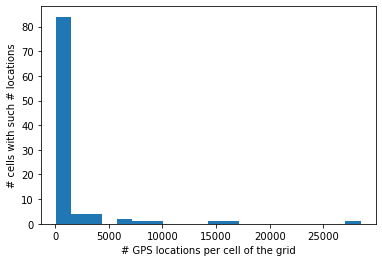

In [12]:
def plot_cell_containment(grid: Grid, threshold: int, bins = 20):
    ''''''
    wow = pd.Series([grid.cell_list[i].number_of_locations for i in range(grid.latitude_cells_nr*grid.longitude_cells_nr)])
    wow = pd.Series([wow[i] for i in range(len(wow)) if wow[i] > threshold])
    ax = wow.plot(kind='hist', bins=bins)
    ax.set_xlabel("# GPS locations per cell of the grid")
    ax.set_ylabel("# cells with such # locations")
    
plot_cell_containment(grid, threshold=THRESHOLD)

In [13]:
#By grouping per trajectory, we can find the unique vertices each trajectory has traversed!
df_grouped = df.groupby('trajectory')
print(grid.cell_list[12].is_vertex)

False


In [14]:
def find_subsequent_vertex_pairs(df_grouped) -> dict:
    '''if a trajectory has visited vertices: A, A, A, B, C, D, D; we will obtain
    (A, B), (B, C), (C, D) as the key of the resulting dictionary'''

    dic = {}
    
    #For each trajectory, get the list of unique cells it traversed:
    for element in df_grouped['cell_number'].unique():
        
        #Proceed if there was more than 1 cell that was traversed:
        if len(element)>1:
            
            #If the person went from a vertex to a vertex and not just ANY cell:
            if grid.cell_list[int(element[0])].is_vertex and grid.cell_list[int(element[1])].is_vertex:
                
                #Get all pairs of subsequent vertices
                list_of_pairs = [(int(element[i]), int(element[i+1])) for i in range(len(element)-1)]
                
                #Histogram code:
                for pair in list_of_pairs:
                    if pair not in dic:
                        dic[pair] = 1
                    else:
                        dic[pair] += 1

    return dic

In [15]:
#{(213, 7): 5, ...} meaning there are 5 trajectories that went from cell 213 to cell 7 immediately
edges_dict = find_subsequent_vertex_pairs(df_grouped)
edges_dict

{(614, 584): 41,
 (614, 644): 117,
 (554, 584): 101,
 (495, 494): 4,
 (467, 466): 1,
 (466, 437): 1,
 (436, 437): 3,
 (437, 465): 1,
 (465, 495): 1,
 (467, 437): 2,
 (437, 466): 1,
 (466, 436): 2,
 (437, 436): 4,
 (437, 467): 2,
 (584, 614): 48,
 (614, 615): 6,
 (617, 614): 1,
 (644, 614): 29,
 (525, 555): 12,
 (555, 554): 25,
 (615, 614): 1,
 (585, 584): 82,
 (585, 555): 54,
 (434, 435): 2,
 (435, 405): 1,
 (405, 375): 1,
 (375, 344): 1,
 (344, 314): 1,
 (314, 284): 1,
 (284, 254): 1,
 (254, 223): 1,
 (223, 193): 1,
 (193, 163): 1,
 (163, 164): 1,
 (164, 134): 1,
 (134, 135): 1,
 (135, 105): 1,
 (105, 106): 1,
 (106, 76): 1,
 (76, 47): 1,
 (47, 48): 1,
 (48, 18): 1,
 (18, 19): 1,
 (19, 20): 1,
 (20, 21): 1,
 (21, 22): 1,
 (22, 23): 1,
 (23, 24): 1,
 (24, 25): 1,
 (25, 26): 1,
 (26, 27): 1,
 (27, 28): 1,
 (28, 29): 1,
 (495, 525): 7,
 (377, 378): 2,
 (585, 586): 22,
 (586, 585): 23,
 (585, 615): 7,
 (586, 526): 1,
 (527, 526): 4,
 (584, 585): 110,
 (558, 528): 3,
 (616, 586): 8,
 (586,

In [16]:
#Same as above, but filtered by a threshold
edges = [key for key in edges_dict if edges_dict[key] > THRESHOLD_EDGES]
edges[:10]

[(614, 584),
 (614, 644),
 (554, 584),
 (584, 614),
 (644, 614),
 (525, 555),
 (555, 554),
 (585, 584),
 (585, 555),
 (585, 586)]

In [18]:
def rav_graph_to_sven_graph(grid: Grid, edges) -> Graph:
    '''Using the edges list above and a list of vertices from the Grid structure,
    create a Graph object with those vertices and edges to be used in the plotting'''
    
    #This will store all the edges and vertices
    g = Graph()

    #For each cell in the grid:
    for i in range(len(grid.cell_list)):

        if grid.cell_list[i].is_vertex:

            #Create a Sven's Vertex object for this vertex
            #Feel free to change the top-left into bottom-right or the middle coordinates!
            #Altitude is not contained in Cell class!
            v = Vertex(latitude=grid.cell_list[i].top, longitude=grid.cell_list[i].left, altitude=100)

            #See if there are any edges starting from that vertex (ending in that vertex is useless): 
            for edge in edges:
                if edge[0]==i: #or edge[1]==i: #this OR actually makes each edge count twice, I think

                    #Create a Sven's Edge object:
                    e = Edge()

                    #Add the edges one by one to the current Vertex:
                    v.add_edges(e)

            #After all the edges have been added, add the Vertex to the Graph:
            g.add_vertices(v)
            
    return g

In [19]:
v1 = Vertex(latitude=0, longitude=0, altitude=0)
v1.id = 1
v2 = Vertex(latitude=0, longitude=0, altitude=0)
v2.id = 2
v3 = Vertex(latitude=0, longitude=0, altitude=0)
v3.id = 3
g = Graph()
g.add_vertices((v1, v2, v3))

sought_vertex = [vertex for vertex in g.vertices if vertex.id == 2][0]
sought_vertex.id

2

In [20]:
def rav_graph_to_sven_graph_2(grid, edges):
    ''''''
    
    #Create a Graph object:
    g = Graph()
    
    #Create all Vertex objects and add them to the Graph:
    vertex_ids = grid.get_list_of_vertices()
    for ID in vertex_ids:
        #Feel free to change the top-left into bottom-right or the middle coordinates!
        v = Vertex(latitude=grid.cell_list[ID].top, longitude=grid.cell_list[ID].left, altitude=100)
        v.id = ID
        g.add_vertices(v)
        
    #Create all Edge objects - they will have the vertices added (and vertices will have edges added):
    for pair in edges:
        #v1 is the Vertex such that Vertex.ID = pair[0], same for v2
        v1, v2 = [v for v in g.vertices if v.id == pair[0]][0], [v for v in g.vertices if v.id == pair[1]][0]
        
        #Adding vertices to edges:
        e = Edge(vertices=set( (v1, v2) ) )
        
#         #Adding edges to vertices:
#         v1.add_edges(e)
#         v2.add_edges(e)
        
        #AT THIS POINT I ASSUME GRAPH GOT UPDATED BY THE EDGES TOO?
        
    return g

In [26]:
g = rav_graph_to_sven_graph_2(grid, edges)

reduced from 157126 to 99 points


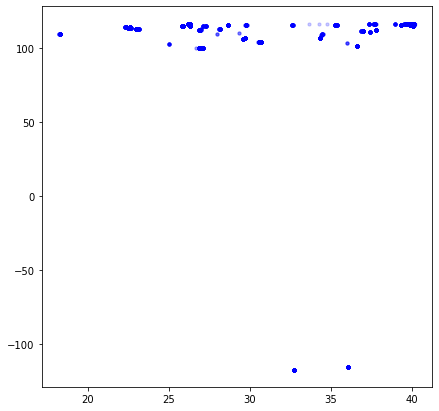

In [32]:
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(df.latitude, df.longitude, zorder=1, alpha= 0.2, c='b', s=10)

# for edge in g.edges:
#     lat1 = min(edge.vertices).latitude
#     long1 = min(edge.vertices).longitude
    
#     lat2 = max(edge.vertices).latitude
#     long2 = max(edge.vertices).longitude
    
#     plt.plot([lat1, lat2], [long1, long2], marker = 'o')

# star_vertices = [vertex for vertex in graph.vertices if len(vertex.edges) == 1]
# for vertex in star_vertices:
#     ax.plot(vertex.latitude, vertex.longitude, markersize=50)
    
ax = plt.gca()
#ax.set_xlim([40.0035, 40.0115])
#ax.set_ylim([116.3175, 116.3245])
print(f"reduced from {len(df)} to {len(g.vertices)} points")

In [36]:
df.latitude.min()

18.2503416

In [22]:
wow = set((2, 1, 3, 7))

In [23]:
wow2 = wow
for element in wow:
    if element==2:
        wow2.remove(element)

RuntimeError: Set changed size during iteration

In [24]:
wow2

{1, 3, 7}

In [25]:
for vertex in g.vertices:
    print(vertex.edges)

set()
set()
set()
{<Edge: (<Vertex: 39.955999999999996,116.33462,100>) -> (<Vertex: 39.974,116.33462,100>)>, <Edge: (<Vertex: 39.955999999999996,116.33462,100>) -> (<Vertex: 39.974,116.33462,100>)>, <Edge: (<Vertex: 39.937999999999995,116.33462,100>) -> (<Vertex: 39.955999999999996,116.33462,100>)>}
{<Edge: (<Vertex: 39.955999999999996,116.35995,100>) -> (<Vertex: 39.974,116.35995,100>)>, <Edge: (<Vertex: 39.955999999999996,116.35995,100>) -> (<Vertex: 39.974,116.35995,100>)>}
set()
set()
set()
set()
set()
set()
set()
set()
set()
{<Edge: (<Vertex: 39.974,116.30929,100>) -> (<Vertex: 39.992,116.30929,100>)>, <Edge: (<Vertex: 39.974,116.30929,100>) -> (<Vertex: 39.974,116.33462,100>)>, <Edge: (<Vertex: 39.974,116.30929,100>) -> (<Vertex: 39.974,116.33462,100>)>, <Edge: (<Vertex: 39.974,116.30929,100>) -> (<Vertex: 39.992,116.30929,100>)>}
{<Edge: (<Vertex: 39.974,116.33462,100>) -> (<Vertex: 39.992,116.33462,100>)>, <Edge: (<Vertex: 39.974,116.33462,100>) -> (<Vertex: 39.974,116.35995,10

In [ ]:
g_not_empty = g.remove_unconnected_vertices